In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.data import Scene, Template, load_measurements_from_yaml
from src.matching import template_match
from src.utils import load_calibration_json
from utils import load_rgb

In [3]:
# Load measurement data
data = load_measurements_from_yaml("../assets/measurements.yaml")

# Load camera calibration
K, dist_coeffs, image_size = load_calibration_json("../assets/camera_calibration.json")

# Load scene and template
scene = data.get_scene("S3")
template = data.get_template("T0")

scene_path = os.path.join(project_root, scene.path)
template_path = os.path.join(project_root, template.path)

scene_image = load_rgb(scene_path)
template_image = load_rgb(template_path)

print(f"{scene}\n")
print(template)

[S3] Both templates - Angled View
* path: assets/images/scene_03.jpg
* distances:
	Camera <-> T0 = 330.0
	Camera <-> T1 = 380.0

[T0] DA Card
* path:   assets/templates/template_00.jpg
* (w, h): 85.0×55.0


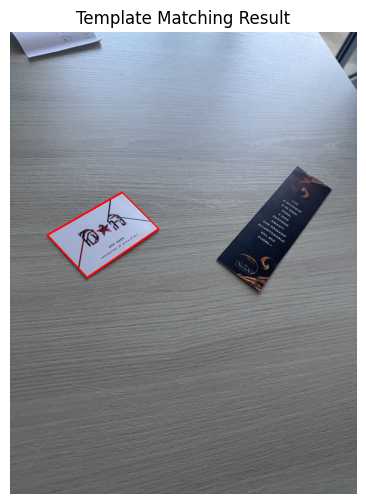

Reprojection error: 0.34


In [4]:
# Compute homography
H, mask, t_shape, reprojection_error = template_match(
    template_path=template_path,
    scene_path=scene_path,
    extract_method='SIFT',
    match_method='BF'
)

print(f"Reprojection error: {reprojection_error:.2f}")

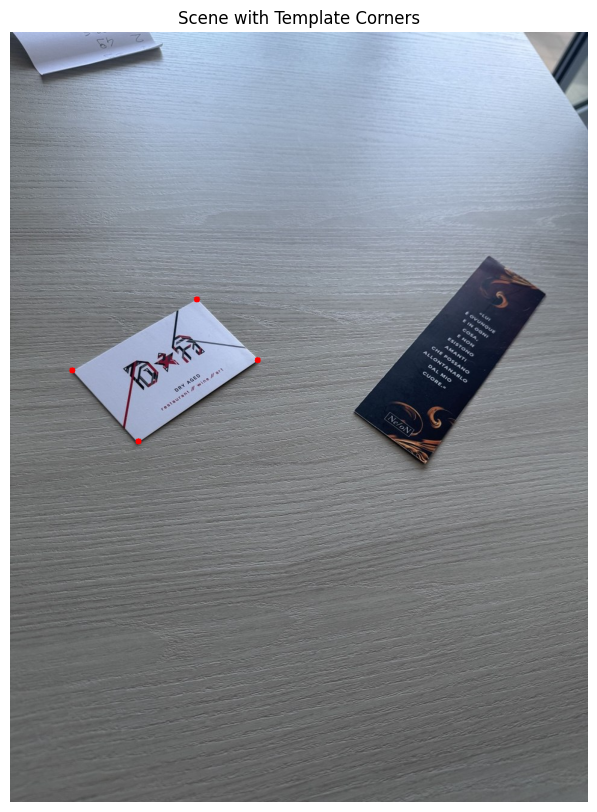

In [5]:
# Draw the four corners of the template on the scene image
h, w = t_shape
corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
corners_transformed = cv2.perspectiveTransform(corners.reshape(-1, 1, 2), H).reshape(-1, 2)

corners_image = scene_image.copy()
for i in range(4):
    cv2.circle(corners_image, tuple(corners_transformed[i].astype(int)), 5, (255, 0, 0), -1)

# Display the scene image with the template corners
plt.figure(figsize=(10, 10))
plt.imshow(corners_image)
plt.title("Scene with Template Corners")
plt.axis('off')
plt.show()

In [6]:
# Add two more points, on the longer sides at a distance of the shorted side from one of the corners of the long sides
if w < h:
    # w short side, draw points on the long side
    additional_points = np.array([
        [w, w], [0, w],
    ])
else:
    # h short side, draw points on the long side
    additional_points = np.array([
        [h, h], [h, 0],
    ])

points = np.vstack((corners, additional_points))
print(f"Points to draw:\n{points}, shape: {points.shape}")

Points to draw:
[[  0.   0.]
 [884.   0.]
 [884. 576.]
 [  0. 576.]
 [576. 576.]
 [576.   0.]], shape: (6, 2)


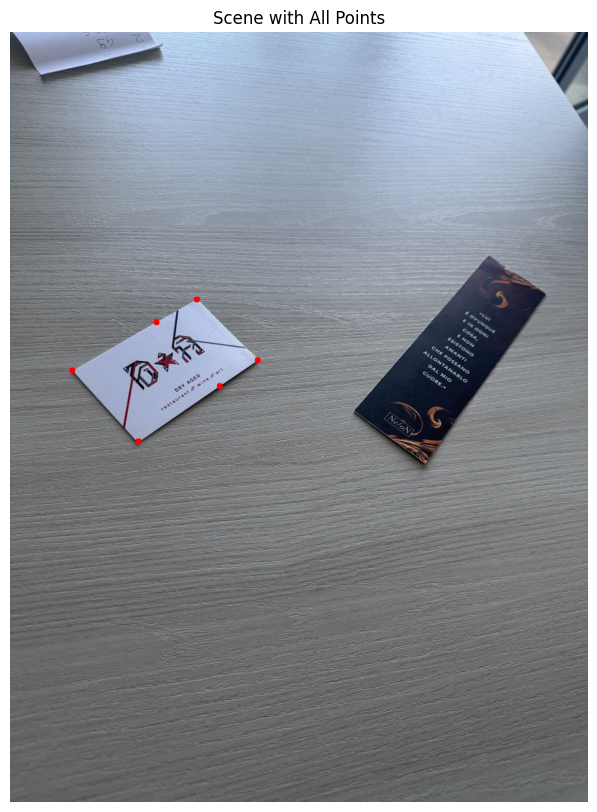

In [7]:
# Draw all the points
points_image = scene_image.copy()
points_transformed = cv2.perspectiveTransform(points.reshape(-1, 1, 2), H).reshape(-1, 2)
for point in points_transformed:
    cv2.circle(points_image, tuple(point.astype(int)), 5, (255, 0, 0), -1)

# Display the scene image with all points
plt.figure(figsize=(10, 10))
plt.imshow(points_image)
plt.title("Scene with All Points")
plt.axis('off')
plt.show()

In [8]:
# Create pairs of points for creating the lines
pairs_idx = np.array([[0, 1], [1, 2], [2, 3], [3, 0], [0, 4], [3, 5]])
pairs = points_transformed[pairs_idx]
print(f"Pairs of points to draw lines:\n{pairs}, shape: {pairs.shape}")

Pairs of points to draw lines:
[[[103.32956836 562.71293237]
  [310.32497715 444.07903632]]

 [[310.32497715 444.07903632]
  [411.29261563 545.39378169]]

 [[411.29261563 545.39378169]
  [213.70506678 680.17560369]]

 [[213.70506678 680.17560369]
  [103.32956836 562.71293237]]

 [[103.32956836 562.71293237]
  [348.02791569 588.54898846]]

 [[213.70506678 680.17560369]
  [243.93968217 482.12599702]]], shape: (6, 2, 2)


In [9]:
def line_from_points(p1, p2):
    """
    Derive the homogeneous line equation from two points.
    """
    # Turn points into homogeneous coordinates
    p1_h = np.array([p1[0], p1[1], 1.0])
    p2_h = np.array([p2[0], p2[1], 1.0])

    # Compute the line equation in homogeneous coordinates
    line = np.cross(p1_h, p2_h)
    return line

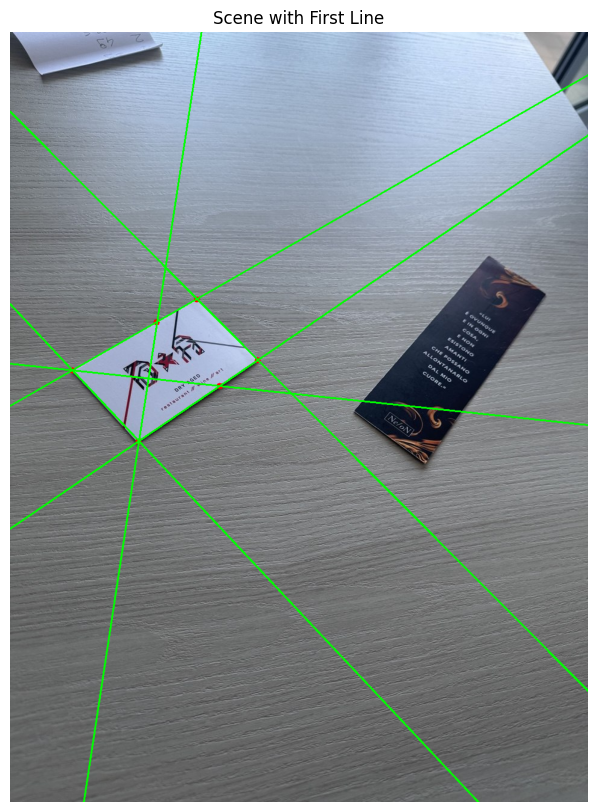

In [10]:
# Compute and plot the first line
lines_image = points_image.copy()
k = 3
for i, (p1, p2) in enumerate(pairs):
    line = line_from_points(p1, p2)
    # Draw the line on the image
    x0, y0 = 0, int(-line[2] / line[1])  # y-intercept
    x1, y1 = lines_image.shape[1], int(-(line[2] + line[0] * lines_image.shape[1]) / line[1])
    cv2.line(lines_image, (x0, y0), (x1, y1), (0, 255, 0), 2)

# Display the scene image with the first line
plt.figure(figsize=(10, 10))
plt.imshow(lines_image)
plt.title("Scene with First Line")
plt.axis('off')
plt.show()

In [11]:
# Create pairs of orthogonal lines
pairs_orthogonal_idx = np.array([
    [[0, 1], [1, 2]],
    [[1, 2], [2, 3]],
    [[2, 3], [3, 0]],
    [[3, 0], [0, 1]],
    [[0, 4], [3, 5]]
])

pairs_orthogonal = np.array([
    [points_transformed[p1], points_transformed[p2]]
    for p1, p2 in pairs_orthogonal_idx
])

pairs_lines = np.array([
    [line_from_points(p1, p2) for p1, p2 in pairs]
    for pairs in pairs_orthogonal
])

def check_orthogonality(line1, line2):
    # Extract direction vectors from homogeneous line equations
    # For line ax + by + c = 0, direction vector is [-b, a]
    dir1 = np.array([-line1[1], line1[0]])
    dir2 = np.array([-line2[1], line2[0]])
    
    # Compute normalized dot product
    dot_product = np.dot(dir1, dir2)
    norm_product = np.linalg.norm(dir1) * np.linalg.norm(dir2)
    
    return dot_product / norm_product

# Apply the check
orthogonality = np.array([
    check_orthogonality(line1, line2)
    for line1, line2 in pairs_lines
])
print(f"Orthogonality check: {orthogonality}")

Orthogonality check: [ 0.26022908 -0.18399131  0.15503745 -0.2317529   0.04628209]


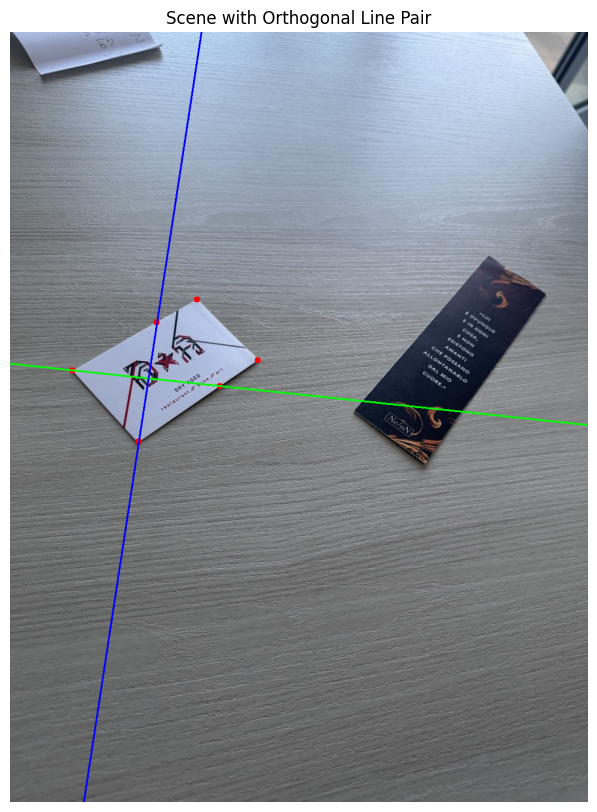

In [12]:
# Plot an orthogonal line pair at a time
ortho_pair_image = points_image.copy()
k = 4
for pair in pairs_lines[k:k+1]:
    line1, line2 = pair

    # Draw the first line
    x0, y0 = 0, int(-line1[2] / line1[1])  # y-intercept
    x1, y1 = ortho_pair_image.shape[1], int(-(line1[2] + line1[0] * ortho_pair_image.shape[1]) / line1[1])
    cv2.line(ortho_pair_image, (x0, y0), (x1, y1), (0, 255, 0), 2)

    # Draw the second line
    x0, y0 = 0, int(-line2[2] / line2[1])  # y-intercept
    x1, y1 = ortho_pair_image.shape[1], int(-(line2[2] + line2[0] * ortho_pair_image.shape[1]) / line2[1])
    cv2.line(ortho_pair_image, (x0, y0), (x1, y1), (0, 0, 255), 2)

# Display the scene image with the orthogonal line pair
plt.figure(figsize=(10, 10))
plt.imshow(ortho_pair_image)
plt.title("Scene with Orthogonal Line Pair")
plt.axis('off')
plt.show()

In [13]:
# Create 5x6 constraint matrix for computing the dual image of the absolute conic
A = np.zeros((5, 6))

# Fill the constraint matrix with the lines
for i, (m, l) in enumerate(pairs_lines):
    A[i, 0] = m[0] * l[0]
    A[i, 1] = m[0] * l[1] + m[1] * l[0]
    A[i, 2] = m[1] * l[1]
    A[i, 3] = m[0] * l[2] + m[2] * l[0]
    A[i, 4] = m[1] * l[2] + m[2] * l[1]
    A[i, 5] = m[2] * l[2]

A.shape

(5, 6)

In [14]:
# Solve the homogeneous system A @ d = 0
U, S, Vt = np.linalg.svd(A)

# The solution is the last row of Vt
d = Vt[-1]

# Reshape the solution into a 3x3 matrix
D = np.array([
    [d[0], d[1], d[3]],
    [d[1], d[2], d[4]],
    [d[3], d[4], d[5]]
])
D

array([[ 9.43324406e-01,  1.18852215e-01,  2.98494593e-04],
       [ 1.18852215e-01,  3.09859821e-01, -1.37576831e-04],
       [ 2.98494593e-04, -1.37576831e-04,  1.98525842e-07]])

In [15]:
# Check that your solution satisfies A @ x ≈ 0
residual = A @ d
print(f"Residual (should be close to zero): {np.linalg.norm(residual)}")
print(f"Smallest singular value: {S[-1]}")
print(f"Singular values: {S}")

Residual (should be close to zero): 1.4534190729121415e-06
Smallest singular value: 1978.861049001529
Singular values: [1.37026302e+10 3.84623868e+07 8.20436600e+06 8.99483086e+03
 1.97886105e+03]


In [16]:
# Rank of D
rank_D = np.linalg.matrix_rank(D)
print(f"Rank of D: {rank_D}")

# Due to noise rank might be full -> enforce rank 2
if rank_D == 3:
    # Compute SVD of D
    U_D, S_D, Vt_D = np.linalg.svd(D)

    print(f"Singular values before enforcing rank 2: {S_D}")
    
    # Set the smallest singular value to zero
    S_D[-1] = 0
    
    # Reconstruct the matrix
    D = U_D @ np.diag(S_D) @ Vt_D
    
    print("Enforcing rank 2 by setting the smallest singular value to zero.")

print(f"Enforced D:\n{D}\nRank: {np.linalg.matrix_rank(D)}")

Rank of D: 3
Singular values before enforcing rank 2: [9.64889682e-01 2.88294744e-01 1.45380357e-15]
Enforcing rank 2 by setting the smallest singular value to zero.
Enforced D:
[[ 9.43324406e-01  1.18852215e-01  2.98494593e-04]
 [ 1.18852215e-01  3.09859821e-01 -1.37576831e-04]
 [ 2.98494593e-04 -1.37576831e-04  1.98525843e-07]]
Rank: 2


In [17]:
# Recover scale of D
scale = 1 / D[1, 1]
D_new = D * scale
D_new

array([[ 3.04435858e+00,  3.83567686e-01,  9.63321390e-04],
       [ 3.83567686e-01,  1.00000000e+00, -4.43997001e-04],
       [ 9.63321390e-04, -4.43997001e-04,  6.40695663e-07]])

In [18]:
import numpy as np

def compute_line_at_infinity(omega_star: np.ndarray) -> np.ndarray:
    """
    Compute the line at infinity l_infinity from the dual conic omega_star.

    Parameters:
        omega_star : np.ndarray
            A 3x3 symmetric matrix representing the dual conic of the circular points.

    Returns:
        l_infinity : np.ndarray
            A 3-element homogeneous vector representing the line at infinity (up to scale).
            The last element will be normalized to 1 if possible.

    Raises:
        ValueError: If omega_star is not 3x3 or has full rank (due to noise, estimation error).
    """
    if omega_star.shape != (3, 3):
        raise ValueError("omega_star must be a 3x3 matrix.")

    # Compute the SVD: omega* = U @ S @ V.T
    _, _, Vt = np.linalg.svd(omega_star)

    # The null vector (last right singular vector) is the line at infinity
    l_inf = Vt[-1]

    print(f"Computed line at infinity (homogeneous coordinates): {l_inf}")

    # Normalize to make the third coordinate 1 (optional, for stability/interpretability)
    # if abs(l_inf[-1]) > 1e-8:
    #     l_inf = l_inf / l_inf[-1]

    return l_inf

In [19]:
# Compute alpha, beta and the line at infinity
alpha = D_new[0, 1]
beta = np.sqrt(D_new[0, 0] - alpha ** 2)
l_infinity = compute_line_at_infinity(D_new)

print(f"Alpha: {alpha}, Beta: {beta}")
print(f"Line at infinity: {l_infinity}")

Computed line at infinity (homogeneous coordinates): [ 3.91277972e-04 -5.94078475e-04 -9.99999747e-01]
Alpha: 0.38356768641551753, Beta: 1.7021264387950363
Line at infinity: [ 3.91277972e-04 -5.94078475e-04 -9.99999747e-01]


In [20]:
def draw_line_at_infinity(image, line_coeffs, color=(0, 255, 0), thickness=2, extend_boundaries=True):
    """
    Draw a line at infinity on an image.
    
    Parameters:
    - image: Input image (numpy array)
    - line_coeffs: Line coefficients [a, b, c] where ax + by + c = 0
    - color: Line color in BGR format (default: green)
    - thickness: Line thickness (default: 2)
    - extend_boundaries: If True, extend search beyond image boundaries
    
    Returns:
    - Image with the line drawn on it
    """
    # Make a copy to avoid modifying the original
    img_copy = image.copy()
    height, width = image.shape[:2]
    
    a, b, c = line_coeffs
    
    print(f"Image dimensions: {width}x{height}")
    print(f"Line coefficients: a={a:.8f}, b={b:.8f}, c={c:.8f}")
    
    # Find intersection points with image boundaries
    points = []
    all_intersections = []  # For debugging
    
    # Check intersection with left edge (x = 0)
    if abs(b) > 1e-10:
        y = -c / b
        all_intersections.append(f"Left edge (x=0): y={y:.2f}")
        if 0 <= y <= height:
            points.append((0, int(y)))
    
    # Check intersection with right edge (x = width-1)
    if abs(b) > 1e-10:
        y = -(a * (width-1) + c) / b
        all_intersections.append(f"Right edge (x={width-1}): y={y:.2f}")
        if 0 <= y <= height:
            points.append((width-1, int(y)))
    
    # Check intersection with top edge (y = 0)
    if abs(a) > 1e-10:
        x = -c / a
        all_intersections.append(f"Top edge (y=0): x={x:.2f}")
        if 0 <= x <= width:
            points.append((int(x), 0))
    
    # Check intersection with bottom edge (y = height-1)
    if abs(a) > 1e-10:
        x = -(b * (height-1) + c) / a
        all_intersections.append(f"Bottom edge (y={height-1}): x={x:.2f}")
        if 0 <= x <= width:
            points.append((int(x), height-1))
    
    print("All boundary intersections:")
    for intersection in all_intersections:
        print(f"  {intersection}")
    
    # Remove duplicate points
    unique_points = []
    for point in points:
        if point not in unique_points:
            unique_points.append(point)
    
    print(f"Valid intersection points: {unique_points}")
    
    if len(unique_points) >= 2:
        # Draw the line using the first two intersection points
        pt1, pt2 = unique_points[0], unique_points[1]
        cv2.line(img_copy, pt1, pt2, color, thickness)
        
        print(f"✓ Line drawn between: {pt1} and {pt2}")
        
    elif extend_boundaries and len(unique_points) < 2:
        # If no intersections within image, try extending the search area
        print("Extending search beyond image boundaries...")
        
        # Create two points along the line for visualization
        if abs(a) > abs(b):  # More vertical line
            x1, x2 = -width, width * 2
            if abs(b) > 1e-10:
                y1 = -(a * x1 + c) / b
                y2 = -(a * x2 + c) / b
            else:
                y1 = y2 = 0
        else:  # More horizontal line
            y1, y2 = -height, height * 2
            if abs(a) > 1e-10:
                x1 = -(b * y1 + c) / a
                x2 = -(b * y2 + c) / a
            else:
                x1 = x2 = 0
        
        # Clip to image boundaries for drawing
        def clip_line_to_image(x1, y1, x2, y2, w, h):
            # Simple clipping - find intersections with image rectangle
            clipped_points = []
            
            # Test all four edges
            edges = [
                (0, 0, w-1, 0),      # top
                (0, h-1, w-1, h-1),  # bottom  
                (0, 0, 0, h-1),      # left
                (w-1, 0, w-1, h-1)   # right
            ]
            
            for edge in edges:
                intersection = line_intersection(x1, y1, x2, y2, edge[0], edge[1], edge[2], edge[3])
                if intersection:
                    ix, iy = intersection
                    if 0 <= ix <= w-1 and 0 <= iy <= h-1:
                        clipped_points.append((int(ix), int(iy)))
            
            return clipped_points[:2] if len(clipped_points) >= 2 else []
        
        clipped_points = clip_line_to_image(x1, y1, x2, y2, width, height)
        
        if len(clipped_points) >= 2:
            pt1, pt2 = clipped_points[0], clipped_points[1]
            cv2.line(img_copy, pt1, pt2, color, thickness)
            print(f"✓ Extended line drawn between: {pt1} and {pt2}")
        else:
            print("✗ Line still does not intersect with image boundaries")
            print(f"Line passes through points: ({x1:.1f}, {y1:.1f}) to ({x2:.1f}, {y2:.1f})")
    
    else:
        print("✗ Line does not intersect with image boundaries")
    
    # Always print the line equation
    print(f"Line equation: {a:.8f}x + {b:.8f}y + {c:.8f} = 0")
    
    return img_copy

def line_intersection(x1, y1, x2, y2, x3, y3, x4, y4):
    """Find intersection of two lines defined by points (x1,y1)-(x2,y2) and (x3,y3)-(x4,y4)"""
    denom = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
    if abs(denom) < 1e-10:
        return None
    
    t = ((x1-x3)*(y3-y4) - (y1-y3)*(x3-x4)) / denom
    
    ix = x1 + t*(x2-x1)
    iy = y1 + t*(y2-y1)
    
    return (ix, iy)

# Example usage with your line at infinity
def test_line_drawing():
    # Your line at infinity coefficients
    line_at_infinity = [-3.91278071e-04, 5.94078625e-04, 1.00000000e+00]
    
    # Create a test image or load your image
    # img = cv2.imread('your_image.jpg')
    
    # For demonstration, create a test image
    test_img = np.zeros((600, 800, 3), dtype=np.uint8)
    test_img.fill(50)  # Dark gray background
    
    # Draw the line
    result_img = draw_line_at_infinity(test_img, line_at_infinity)
    
    # Display the result
    cv2.imshow('Line at Infinity', result_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return result_img

# Alternative function if you want to draw multiple lines
def draw_multiple_lines(image, line_coeffs_list, colors=None, thickness=2):
    """
    Draw multiple lines on an image.
    
    Parameters:
    - image: Input image
    - line_coeffs_list: List of line coefficients [[a1,b1,c1], [a2,b2,c2], ...]
    - colors: List of colors for each line (optional)
    - thickness: Line thickness
    """
    if colors is None:
        colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0)]
    
    result = image.copy()
    
    for i, line_coeffs in enumerate(line_coeffs_list):
        color = colors[i % len(colors)]
        result = draw_line_at_infinity(result, line_coeffs, color, thickness)
    
    return result

# Uncomment to test:
test_line_drawing()

Image dimensions: 800x600
Line coefficients: a=-0.00039128, b=0.00059408, c=1.00000000
All boundary intersections:
  Left edge (x=0): y=-1683.28
  Right edge (x=799): y=-1157.03
  Top edge (y=0): x=2555.73
  Bottom edge (y=599): x=3465.19
Valid intersection points: []
Extending search beyond image boundaries...
✗ Line still does not intersect with image boundaries
Line passes through points: (1644.7, -600.0) to (4377.7, 1200.0)
Line equation: -0.00039128x + 0.00059408y + 1.00000000 = 0


array([[[50, 50, 50],
        [50, 50, 50],
        [50, 50, 50],
        ...,
        [50, 50, 50],
        [50, 50, 50],
        [50, 50, 50]],

       [[50, 50, 50],
        [50, 50, 50],
        [50, 50, 50],
        ...,
        [50, 50, 50],
        [50, 50, 50],
        [50, 50, 50]],

       [[50, 50, 50],
        [50, 50, 50],
        [50, 50, 50],
        ...,
        [50, 50, 50],
        [50, 50, 50],
        [50, 50, 50]],

       ...,

       [[50, 50, 50],
        [50, 50, 50],
        [50, 50, 50],
        ...,
        [50, 50, 50],
        [50, 50, 50],
        [50, 50, 50]],

       [[50, 50, 50],
        [50, 50, 50],
        [50, 50, 50],
        ...,
        [50, 50, 50],
        [50, 50, 50],
        [50, 50, 50]],

       [[50, 50, 50],
        [50, 50, 50],
        [50, 50, 50],
        ...,
        [50, 50, 50],
        [50, 50, 50],
        [50, 50, 50]]], shape=(600, 800, 3), dtype=uint8)

Image dimensions: 960x1280
Line coefficients: a=0.00039128, b=-0.00059408, c=-0.99999975
All boundary intersections:
  Left edge (x=0): y=-1683.28
  Right edge (x=959): y=-1051.65
  Top edge (y=0): x=2555.73
  Bottom edge (y=1279): x=4497.64
Valid intersection points: []
Extending search beyond image boundaries...
✗ Line still does not intersect with image boundaries
Line passes through points: (612.3, -1280.0) to (6442.6, 2560.0)
Line equation: 0.00039128x + -0.00059408y + -0.99999975 = 0


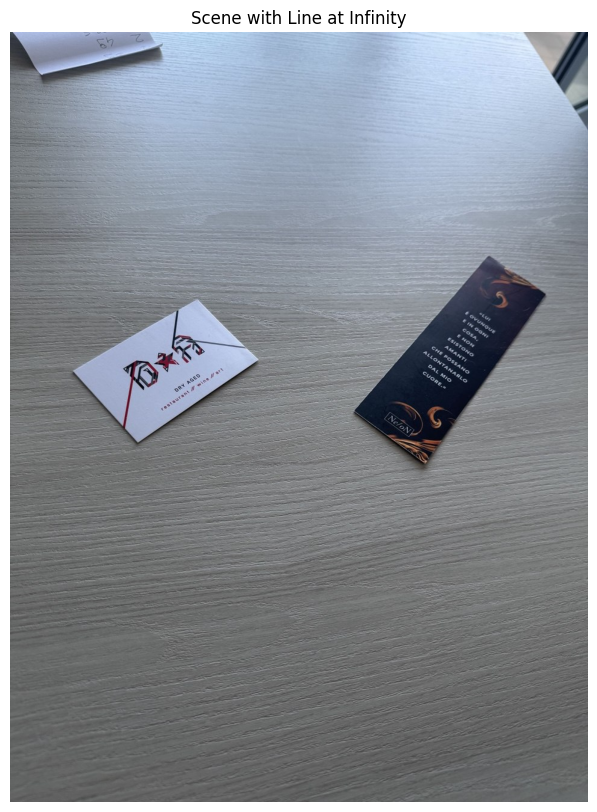

In [21]:
# Draw the line at infinity on the scene image
line_at_infinity_image = draw_line_at_infinity(scene_image, l_infinity)

# Display the scene image with the line at infinity
plt.figure(figsize=(10, 10))
plt.imshow(line_at_infinity_image)
plt.title("Scene with Line at Infinity")
plt.axis('off')
plt.show()

In [22]:
K

array([[894.67311331,   0.        , 485.2289589 ],
       [  0.        , 896.1589482 , 633.03618469],
       [  0.        ,   0.        ,   1.        ]])

In [23]:
a = K[0, 0] / K[1, 1]
a ** 2

np.float64(0.9966867414855395)

In [24]:
a = np.sqrt(D[0, 0])
u0 = -D[0, 2] / D[0, 0]
v0 = -D[1, 2]
fy = np.sqrt(D[2, 2] - D[0, 0] * (u0 ** 2 - v0 ** 2))
fx = fy / a

K_est = np.array([
    [fx, 0, u0],
    [0, fy, v0],
    [0, 0, 1]
])
K_est

array([[ 3.59518976e-04,  0.00000000e+00, -3.16428359e-04],
       [ 0.00000000e+00,  3.49182406e-04,  1.37576831e-04],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
# Try with Zhang's formulas to recover the camera matrix
# b = [B11, B12, B22, B13, B23, B33]
B11, B12, B22, B13, B23, B33 = d

print(f"Computed B coefficients: {B11}, {B12}, {B22}, {B13}, {B23}, {B33}")

# Compute intrinsic parameters from B
cy = (B12 * B13 - B11 * B23) / (B11 * B22 - B12**2)
scale = B33 - (B13**2 + cy * (B12 * B13 - B11 * B23)) / B11
fx = np.sqrt(scale / B11)
fy = np.sqrt(scale * B11 / (B11 * B22 - B12**2))
s = -B12 * fx**2 * fy / scale
cx = s * cy / fy - B13 * fx**2 / scale

# Construct the intrinsic matrix
K_zhang = np.array([
    [fx, s, cx],
    [0, fy, cy],
    [0, 0, 1]
])

print("Estimated camera matrix K from Zhang's formulas:")
print(K_zhang)

Computed B coefficients: 0.9433244057051999, 0.11885221464122822, 0.30985982096645137, 0.00029849459347475817, -0.00013757683108849732, 1.9852584189562076e-07
Computed scale: -1.45380423139631e-15
Estimated camera matrix K from Zhang's formulas:
[[           nan            nan            nan]
 [0.00000000e+00            nan 5.94078625e-04]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


/tmp/ipykernel_14282/2004596660.py:11: RuntimeWarning: invalid value encountered in sqrt
  fx = np.sqrt(scale / B11)
/tmp/ipykernel_14282/2004596660.py:12: RuntimeWarning: invalid value encountered in sqrt
  fy = np.sqrt(scale * B11 / (B11 * B22 - B12**2))
